In [1]:
import pandas as pd
import numpy as np
import category_encoders
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [2]:
%time df = pd.read_feather('../data/labeled/labeled_1597265676.feather')
df.head()

CPU times: user 1.01 s, sys: 800 ms, total: 1.81 s
Wall time: 323 ms


,index,transaction_datetime,user_id,business_account_number,transaction_code,is_return,transaction_amount,endbal,external_account_number,real_ending_balance,...,nr_returns_all_time,days_to_acc_close,account_closed_by_risk_in_next_90d,is_chg_wrt_off_in_90d,nr_returns_in_next_90d,bal_after_90d,tamt_abs,is_returned,target,indeterminate
0,0,2017-12-13 16:26:31,65740,410000007044,ACHDD,False,500.0,500.00,80001475699,500.00,...,1.0,NaN,False,False,1.0,2386.24,500.0,False,False,False
1,1,2018-01-04 18:43:31,65740,410000007044,ACHDD,False,75.0,558.29,80001475699,558.29,...,1.0,NaN,False,False,1.0,3887.73,75.0,False,False,False
2,3,2018-01-24 20:14:12,65740,410000007044,ACHDD,False,100.0,520.27,80001475699,520.27,...,1.0,NaN,False,False,0.0,903.40,100.0,False,False,False
3,4,2018-01-26 10:53:36,65740,410000007044,ACHDD,False,125.0,645.27,80001475699,645.27,...,1.0,NaN,False,False,0.0,903.40,125.0,False,False,False
4,5,2018-01-27 12:10:55,65740,410000007044,ACHDD,False,150.0,794.77,80001475699,794.77,...,1.0,NaN,False,False,0.0,1400.27,150.0,False,False,False


In [3]:
df['is_returned'].value_counts()

False    544946
True      14519
Name: is_returned, dtype: int64

In [4]:
df[df['is_returned']]['transaction_amount'].agg(['mean', 'sum'])

mean    1.703121e+03
sum     2.472762e+07
Name: transaction_amount, dtype: float64

In [5]:
# df['closed_by_risk_or_chg_off'] = (~df['chg_wrt_off_date'].isna()) | \
#     df['closed_reason'].isin(['Closed by SoFi - Risk Request', 
#                               'Closed by SoFi - Charge-Off / Write-Off'])
# df['closed_by_risk_or_chg_off'].value_counts()
df['account_closed_by_risk_in_next_90d'].value_counts()

False    551111
True       8354
Name: account_closed_by_risk_in_next_90d, dtype: int64

In [6]:
"""False    548590
True      10875"""
# df['closed_by_risk_or_chg_off'] = df['closed_reason'].isin(['Closed by SoFi - Risk Request', 
#                               'Closed by SoFi - Charge-Off / Write-Off'])
# df['closed_by_risk_or_chg_off'].value_counts()

'False    548590\nTrue      10875'

In [7]:
# We are taking the dataframe from 2019-1-16 to 2020-02-14 for training
modeling_df = df[df['transaction_datetime'].between(pd.to_datetime('2019-01-16'), 
                                                    pd.to_datetime('2020-02-14'))]

In [8]:
# how much money was involved
df_ = modeling_df
df_[df_.is_returned].transaction_amount.mean(), df_[df_.is_returned].transaction_amount.sum()

(1973.5368153876661, 19905092.32)

In [9]:
len(modeling_df) / len(df), " as training/validation data"

(0.6249059369218807, ' as training/validation data')

#### Nr days takes to close an account

In [11]:
modeling_df.columns[modeling_df.columns.str.contains('date')]

Index(['transaction_datetime', 'credit_pull_date', 'giact_created_date',
       'giact_first_link_date', 'giact_last_link_date',
       'quovo_first_link_date', 'quovo_last_link_date',
       'plaid_first_link_date', 'plaid_last_link_date',
       'last_unrestricted_date', 'first_restricted_by_risk_date',
       'first_transaction_datetime', 'last_transaction_datetime',
       'first_return_date', 'chg_wrt_off_date'],
      dtype='object')

<AxesSubplot:>

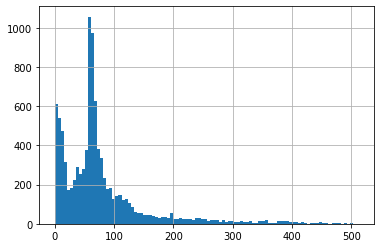

In [12]:
modeling_df['chg_off_by_risk'] = df['closed_reason'].isin(['Closed by SoFi - Risk Request', 
                                                                         'Closed by SoFi - Charge-Off / Write-Off'])
modeling_df[modeling_df.chg_off_by_risk]['days_to_acc_close'].hist(bins=100)

<AxesSubplot:>

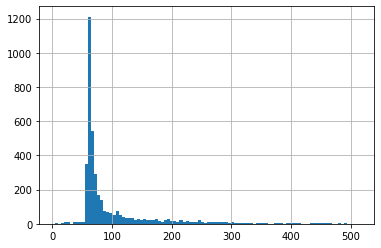

In [13]:
modeling_df['nr_days_to_chg_wrt_off'] = (modeling_df['chg_wrt_off_date'] - modeling_df['transaction_datetime']).dt.days
modeling_df[modeling_df.chg_off_by_risk]['nr_days_to_chg_wrt_off'].hist(bins=100)

<AxesSubplot:>

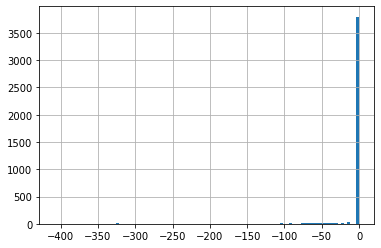

In [63]:
# dtc > chg_wrt_off_date, which makes sense. 
# first a bad transaction appear, then the account is closed
temp_df = modeling_df[(~modeling_df.chg_wrt_off_date.isna()) & (~modeling_df.dtc.isna())]
(temp_df['chg_wrt_off_date'].dt.date - temp_df['dtc']).dt.days.hist(bins=100)

In [36]:
# on average takes 97 days 
df_w_chg_off.nr_days_to_chg_wrt_off.describe()

count    4020.000000
mean       97.992040
std        69.972905
min         4.000000
25%        62.000000
50%        69.000000
75%        98.000000
max       514.000000
Name: nr_days_to_chg_wrt_off, dtype: float64

In [37]:
# 68 percent of the target was written off
len(df_w_chg_off) / len(modeling_df[(modeling_df.target) & (~modeling_df.indeterminate)])

0.6818181818181818

#### Indeterminant only after balance went positive after 90 days

In [14]:
# We are taking the dataframe from 2019-1-16 to 2020-02-14 for training
modeling_df = df[df['transaction_datetime'].between(pd.to_datetime('2019-01-16'), 
                                                    pd.to_datetime('2020-02-14'))]
modeling_df['indeterminate1'] = modeling_df['is_returned'] & (modeling_df['bal_after_90d'] > 0)
display(modeling_df[['target', 'indeterminate1']].value_counts())
modeling_df = modeling_df[~modeling_df['indeterminate1']]

target  indeterminate1
False   False             339527
True    True                5169
        False               4917
dtype: int64

In [15]:
df_ = modeling_df
df_[df_.target].transaction_amount.mean(), df_[df_.target].transaction_amount.sum()

(1894.6941509050234, 9316211.14)

In [16]:
modeling_df[modeling_df.target].transaction_amount.agg(['sum', 'mean']).round(2)

sum     9316211.14
mean       1894.69
Name: transaction_amount, dtype: float64

<AxesSubplot:>

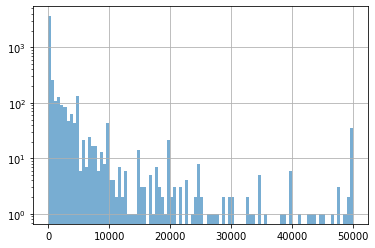

In [17]:
modeling_df[modeling_df['target']]['transaction_amount'].hist(bins=100, log=True, alpha=0.6)

target
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: transaction_amount, dtype: object

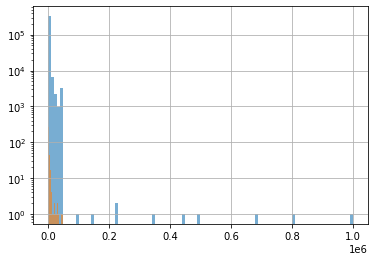

In [18]:
modeling_df.groupby('target')['transaction_amount'].hist(bins=100, log=True, alpha=0.6)

#### Indeterminant if balance after 90 days >= 0 and not closed by risk or being charged off

In [19]:
# We are taking the dataframe from 2019-1-16 to 2020-02-14 for training
modeling_df = df[df['transaction_datetime'].between(pd.to_datetime('2019-01-16'), 
                                                    pd.to_datetime('2020-02-14'))]
modeling_df['indeterminate2'] = (modeling_df['is_returned'] & ((modeling_df['bal_after_90d'] > 0) & 
                                                             (~modeling_df['account_closed_by_risk_in_next_90d']))) \
                                | (~modeling_df['is_returned'] & ((modeling_df['account_closed_by_risk_in_next_90d']) ))

# how much dollar value are we excluding by removing indeterminates?
display(modeling_df[modeling_df.target][['transaction_amount', 'indeterminate2']].agg(['mean', 'sum']))

modeling_df = modeling_df[~modeling_df['indeterminate2']]
display(modeling_df['target'].value_counts())

,transaction_amount,indeterminate2
mean,1.973537e+03,0.415427
sum,1.990509e+07,4190.000000


False    336115
True       5896
Name: target, dtype: int64

In [20]:
modeling_df.closed_reason.unique()

array([None, 'Closed by SoFi - Charge-Off / Write-Off',
       'Customer Request', 'Closing to Open Joint Account',
       'Funds Availability', 'Closed by SoFi - Risk Request',
       'Missing Features / Benefits', 'Closed by SoFi - Deceased',
       'Went to Competitor', 'Unhappy with Service', 'Moving Outside US',
       'Closed by SoFi - Failed KYC', 'Member Security Concerns',
       'Opened in Error'], dtype=object)

In [21]:
df_ = modeling_df
df_[df_.target].transaction_amount.mean(), df_[df_.target].transaction_amount.sum(), df_.transaction_amount.sum()

(1792.4121166892808, 10568061.84, 675525264.4500003)

#### Final definition

Check src/data.py for detail

In [34]:
modeling_df = df[df['transaction_datetime'].between(pd.to_datetime('2019-01-16'), 
                                                    pd.to_datetime('2020-02-14'))]
print(sum(modeling_df.indeterminate))
display(modeling_df[modeling_df.target][['transaction_amount', 'indeterminate']].agg(['mean', 'sum']))
modeling_df = modeling_df[~modeling_df.indeterminate]

7602


,transaction_amount,indeterminate
mean,1.973537e+03,0.415427
sum,1.990509e+07,4190.000000


In [35]:
modeling_df.target.value_counts()

False    336115
True       5896
Name: target, dtype: int64

### First Bad vs. Ever Bad
---

We need to look into the difference between the first bad and the ever bad target. Using a fraud transaction as an example, with our definition, an ACH transaction is labeled bad if it is returned and the account balance went negative after 90 days. However, the account balance may recover after 91 days. 

In this case, if we select a performance window of 91, the transaction would be labeled good.

This definition would cause noise in the target. On the otherhand, we may go with a stricter definition, that instead of finding the target with the time cut off exactly at 90 days, a transaction will be labeled as bad if it turned "bad" for any time within the performance window. This would offer a more consistent model target behavior, but it is possible would affect some user experience.

In [2]:
cols = modeling_df.columns

NameError: name 'modeling_df' is not defined

#### Ever Definition
---

In [3]:
# we have the ever definition here
# modeling_df['target_90d'] = modeling_df['target']
# modeling_df['indeterminate_90d'] = modeling_df['indeterminate']

In [4]:
from pandas.tseries.offsets import BDay
from tqdm import tqdm

def reverse_df(df):
    """ Helper for forward looking rolling function """
    # reverse dataset
    reverse_df = df.iloc[::-1]
    ri = reverse_df.index

    # re-reverse index
    reverse_df.index = ri[0] - ri + ri[-1]

    return reverse_df

NDAYS = 90

def get_nr_returns_nd(df):
    global NDAYS
    return reverse_df(reverse_df(df).rolling(f'{NDAYS}d', min_periods=1)['is_return'].sum())

def get_bal_after_nd(df):
    global NDAYS
    return reverse_df(reverse_df(df).rolling(f'{NDAYS}d', min_periods=1)['real_ending_balance'].apply(lambda a: a[0], raw=True))

def applyParallel(dfGrouped, func):
    """ Helper to parallelize apply over groupby """
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)

def match_ach_returns(df, timedelta=BDay(3)):
    """
    Check if ACH transactions are returned with some timeframe.
    """
    #For performance purposes...
    df = df[df['transaction_code'].isin(['ACHDD', 'DWACHRET'])]
    
    df = df.reset_index(drop=True)

    df['tamt_abs'] = df['transaction_amount'].abs()
    df['is_returned'] = False
    
    for act_n, transaction in tqdm(df[df['is_return'] == 1].iterrows()):
        
        tdt_hi = transaction['transaction_datetime']
        tdt_lo = tdt_hi - timedelta

        dcandidate = df[df['business_account_number'] == transaction['business_account_number']]

        dret = dcandidate[(dcandidate['transaction_datetime'].between(tdt_lo, tdt_hi)) & \
                          (dcandidate['tamt_abs'] == transaction['tamt_abs'])]
        
        df.loc[dret.index, 'is_returned'] = True

    df = df.reset_index(drop=True)
    return df


In [5]:
from multiprocessing import Pool, cpu_count

def get_labels_nd(df, n_days=90):
    """
    Get add labels to processed data.
    """
    # sort data for roll-ups
    global NDAYS
    NDAYS = n_days
    print(f'Ndays = {NDAYS}')
    
    df = df.sort_values(by=['business_account_number', 'transaction_datetime'])
    df['days_to_acc_close'] = (pd.to_datetime(df['dtc']) - df['transaction_datetime']).dt.days
    df['account_closed_by_risk_in_next_nd'] = df['closed_reason'].isin(['Closed by SoFi - Risk Request', 
                                                                         'Closed by SoFi - Charge-Off / Write-Off']) &\
                                               (df['days_to_acc_close'] <= n_days)
    # does account chg/wrt off in next 90 days?
    df['is_chg_wrt_off_in_nd'] = (df['chg_wrt_off_date'] - df['transaction_datetime']).dt.days <= n_days

    # Set index to transaction datetime.
    df = df.set_index('transaction_datetime')

    df['bal_after_nd'] = applyParallel(df[['business_account_number', 
                                           'real_ending_balance']].groupby('business_account_number'), 
                                                     get_bal_after_nd).values
    df['nr_returns_in_next_nd'] = applyParallel(df[['business_account_number', 
                                                    'is_return']].groupby('business_account_number'), 
                                                 get_nr_returns_nd).values
    df = df.reset_index()

    df = match_ach_returns(df)
    
    # drop non ACH types
    df = df[df['transaction_code'].isin(['ACHDD']) & (df['transaction_amount'] > 0)]

    def get_target(df):
        """
        for now: bad if this transaction is returned in next 3 business days, good otherwise.
        
        Note: want to exclude/indeterminate R10 returns* -- Notex2 - decided not to do this since it's too imprecise.

        BAD - this specific ACH transaction returns within the next 3 business days.
        Consider indeterminating accounts with ++ balance that have returns, not closed off by risk
        and accounts with no ach return but closed off by risk.
        """
        df['target'] = df['is_returned']
        
        df['indeterminate'] = (df['target'] & ((df['bal_after_nd'] > 0) & 
                                             (~df['account_closed_by_risk_in_next_nd']))) \
                              | (~df['target'] & df['account_closed_by_risk_in_next_nd'])
        
        return df

    df = get_target(df)
    
    if 'level_0' in df.columns:
        df = df.drop('level_0', axis=1)
    
    return df.reset_index()

In [7]:
modeling_df = pd.read_feather('../data/labeled/labeled_1597354481.feather')
modeling_df = modeling_df[modeling_df["transaction_datetime"].between(pd.to_datetime('2019-01-16'),
                                                    pd.to_datetime('2020-02-14'))]

In [17]:
df = pd.read_feather('../data/features/features_1597354171.feather')
%time df_debug = get_labels_nd(df, n_days=90)
df_debug = df_debug[df_debug['transaction_datetime'].between(pd.to_datetime('2019-01-16'), 
                                                    pd.to_datetime('2020-02-14'))]

Ndays = 90


17810it [00:57, 307.26it/s]


CPU times: user 4min 2s, sys: 38.5 s, total: 4min 40s
Wall time: 4min 46s


In [8]:
def sort_dfs(df):
    df.sort_values(by=['business_account_number', 'transaction_datetime', 'transaction_amount'], inplace=True)

# sort_dfs(modeling_df)
# sort_dfs(df_debug)

In [ ]:
# generate comparable dfs for n = [10, 20, 30, 40, 50, 60, 70, 80, 90]
df = pd.read_feather('../data/features/features_1597354171.feather')
meta_cols = ['business_account_number', 'transaction_datetime', 'transaction_amount', 
             'target', 'indeterminate', 'dtc', 'closed_reason', 'days_to_acc_close', 'account_closed_by_risk_in_next_nd', 
             'is_chg_wrt_off_in_nd', 'chg_wrt_off_date', 'bal_after_nd', 'real_ending_balance', 
             'nr_returns_in_next_nd', 'is_return', 'transaction_code']
dfs = {}
for n in tqdm([10, 20, 30, 40, 50, 60, 70, 80, 90]):
    df_debug = get_labels_nd(df, n_days=n)
    df_debug = df_debug[df_debug['transaction_datetime'].between(pd.to_datetime('2019-01-16'), 
                                                                 pd.to_datetime('2020-02-14'))]
    sort_dfs(df_debug)
    dfs[n] = df_debug[meta_cols]
    
import pickle as pkl
pkl.dump(dfs, open('../artifacts/ach-target-ever.pkl', 'wb'))

  0%|          | 0/9 [00:00<?, ?it/s]

Ndays = 10



0it [00:00, ?it/s]
1it [00:01,  1.27s/it]
33it [00:01,  1.13it/s]
65it [00:01,  1.60it/s]
97it [00:01,  2.29it/s]
129it [00:01,  3.26it/s]
161it [00:01,  4.63it/s]
193it [00:01,  6.58it/s]
225it [00:01,  9.31it/s]
257it [00:02, 13.13it/s]
289it [00:02, 18.43it/s]
320it [00:02, 25.66it/s]
351it [00:02, 35.40it/s]
382it [00:02, 48.21it/s]
413it [00:02, 64.53it/s]
445it [00:02, 84.65it/s]
477it [00:02, 108.34it/s]
508it [00:02, 134.48it/s]
539it [00:03, 161.81it/s]
571it [00:03, 188.94it/s]
602it [00:03, 213.32it/s]
633it [00:03, 235.08it/s]
665it [00:03, 253.64it/s]
696it [00:03, 268.03it/s]
727it [00:03, 274.61it/s]
758it [00:03, 283.63it/s]
790it [00:03, 291.22it/s]
822it [00:03, 296.93it/s]
853it [00:04, 300.69it/s]
884it [00:04, 302.03it/s]
915it [00:04, 302.62it/s]
947it [00:04, 304.96it/s]
978it [00:04, 305.85it/s]
1010it [00:04, 307.23it/s]
1042it [00:04, 308.52it/s]
1073it [00:04, 307.46it/s]
1105it [00:04, 308.28it/s]
1136it [00:04, 308.32it/s]
1168it [00:05, 308.84it/s]
1199it

Ndays = 20



0it [00:00, ?it/s]
1it [00:01,  1.27s/it]
33it [00:01,  1.13it/s]
65it [00:01,  1.60it/s]
97it [00:01,  2.29it/s]
129it [00:01,  3.26it/s]
161it [00:01,  4.63it/s]
193it [00:01,  6.58it/s]
224it [00:01,  9.31it/s]
255it [00:02, 13.13it/s]
286it [00:02, 18.41it/s]
318it [00:02, 25.66it/s]
349it [00:02, 35.38it/s]
380it [00:02, 48.18it/s]
412it [00:02, 64.61it/s]
444it [00:02, 84.80it/s]
475it [00:02, 108.37it/s]
506it [00:02, 134.51it/s]
538it [00:02, 162.52it/s]
570it [00:03, 190.13it/s]
602it [00:03, 214.95it/s]
634it [00:03, 236.01it/s]
665it [00:03, 254.16it/s]
696it [00:03, 268.54it/s]
728it [00:03, 280.86it/s]
760it [00:03, 289.02it/s]
792it [00:03, 296.29it/s]
824it [00:03, 300.62it/s]
856it [00:04, 304.20it/s]
888it [00:04, 307.43it/s]
920it [00:04, 309.62it/s]
952it [00:04, 309.04it/s]
984it [00:04, 311.07it/s]
1016it [00:04, 312.10it/s]
1048it [00:04, 312.35it/s]
1080it [00:04, 313.32it/s]
1112it [00:04, 312.40it/s]
1144it [00:04, 312.09it/s]
1176it [00:05, 313.34it/s]
1208it

Ndays = 30



0it [00:00, ?it/s]
1it [00:01,  1.26s/it]
33it [00:01,  1.14it/s]
65it [00:01,  1.62it/s]
97it [00:01,  2.31it/s]
129it [00:01,  3.29it/s]
161it [00:01,  4.67it/s]
193it [00:01,  6.63it/s]
225it [00:01,  9.39it/s]
257it [00:02, 13.25it/s]
289it [00:02, 18.59it/s]
321it [00:02, 25.91it/s]
353it [00:02, 35.75it/s]
385it [00:02, 48.71it/s]
417it [00:02, 65.30it/s]
449it [00:02, 85.71it/s]
481it [00:02, 109.70it/s]
513it [00:02, 136.42it/s]
545it [00:02, 164.15it/s]
577it [00:03, 191.74it/s]
609it [00:03, 217.47it/s]
641it [00:03, 239.87it/s]
673it [00:03, 258.22it/s]
705it [00:03, 272.83it/s]
737it [00:03, 284.75it/s]
769it [00:03, 292.96it/s]
801it [00:03, 298.39it/s]
833it [00:03, 303.72it/s]
865it [00:03, 307.54it/s]
897it [00:04, 309.37it/s]
929it [00:04, 310.99it/s]
961it [00:04, 312.70it/s]
993it [00:04, 313.82it/s]
1025it [00:04, 313.77it/s]
1057it [00:04, 312.67it/s]
1089it [00:04, 312.37it/s]
1121it [00:04, 311.58it/s]
1153it [00:04, 312.53it/s]
1185it [00:05, 313.91it/s]
1217it

Ndays = 40



0it [00:00, ?it/s]
1it [00:01,  1.44s/it]
33it [00:01,  1.01s/it]
65it [00:01,  1.42it/s]
97it [00:01,  2.02it/s]
129it [00:01,  2.88it/s]
161it [00:01,  4.09it/s]
192it [00:02,  5.81it/s]
224it [00:02,  8.24it/s]
255it [00:02, 11.63it/s]
285it [00:02, 16.33it/s]
315it [00:02, 22.79it/s]
345it [00:02, 31.51it/s]
375it [00:02, 43.01it/s]
405it [00:02, 57.78it/s]
435it [00:02, 75.93it/s]
464it [00:03, 93.92it/s]
496it [00:03, 118.66it/s]
524it [00:03, 139.89it/s]
554it [00:03, 165.87it/s]
584it [00:03, 191.33it/s]
614it [00:03, 213.41it/s]
644it [00:03, 233.12it/s]
674it [00:03, 249.67it/s]
704it [00:03, 261.20it/s]
736it [00:03, 274.83it/s]
768it [00:04, 285.18it/s]
800it [00:04, 292.86it/s]
832it [00:04, 299.11it/s]
864it [00:04, 303.63it/s]
896it [00:04, 306.86it/s]
928it [00:04, 308.65it/s]
960it [00:04, 310.15it/s]
992it [00:04, 311.79it/s]
1024it [00:04, 312.50it/s]
1056it [00:04, 313.18it/s]
1088it [00:05, 313.61it/s]
1120it [00:05, 313.29it/s]
1152it [00:05, 313.31it/s]
1184it [

Ndays = 50



0it [00:00, ?it/s]
1it [00:01,  1.41s/it]
33it [00:01,  1.01it/s]
65it [00:01,  1.44it/s]
97it [00:01,  2.05it/s]
129it [00:01,  2.92it/s]
161it [00:01,  4.16it/s]
193it [00:02,  5.91it/s]
225it [00:02,  8.38it/s]
257it [00:02, 11.83it/s]
289it [00:02, 16.64it/s]
321it [00:02, 23.24it/s]
353it [00:02, 32.19it/s]
385it [00:02, 44.08it/s]
417it [00:02, 59.44it/s]
449it [00:02, 78.54it/s]
481it [00:02, 101.45it/s]
513it [00:03, 127.37it/s]
545it [00:03, 155.25it/s]
577it [00:03, 183.11it/s]
609it [00:03, 209.94it/s]
641it [00:03, 233.66it/s]
673it [00:03, 253.81it/s]
705it [00:03, 269.09it/s]
737it [00:03, 281.44it/s]
769it [00:03, 289.62it/s]
801it [00:03, 297.54it/s]
833it [00:04, 302.27it/s]
865it [00:04, 305.42it/s]
897it [00:04, 306.90it/s]
929it [00:04, 309.70it/s]
961it [00:04, 311.91it/s]
993it [00:04, 313.03it/s]
1025it [00:04, 314.50it/s]
1057it [00:04, 314.53it/s]
1089it [00:04, 315.11it/s]
1121it [00:04, 315.91it/s]
1153it [00:05, 316.14it/s]
1185it [00:05, 317.07it/s]
1217it

Ndays = 60



0it [00:00, ?it/s]
1it [00:01,  1.42s/it]
33it [00:01,  1.01it/s]
65it [00:01,  1.44it/s]
97it [00:01,  2.05it/s]
129it [00:01,  2.92it/s]
161it [00:01,  4.16it/s]
193it [00:02,  5.91it/s]
225it [00:02,  8.37it/s]
257it [00:02, 11.82it/s]
289it [00:02, 16.62it/s]
321it [00:02, 23.22it/s]
353it [00:02, 32.14it/s]
385it [00:02, 43.98it/s]
417it [00:02, 59.26it/s]
449it [00:02, 78.29it/s]
481it [00:02, 101.05it/s]
513it [00:03, 126.80it/s]
545it [00:03, 154.45it/s]
577it [00:03, 182.17it/s]
609it [00:03, 208.76it/s]
641it [00:03, 232.62it/s]
673it [00:03, 250.90it/s]
705it [00:03, 267.36it/s]
737it [00:03, 279.76it/s]
769it [00:03, 289.22it/s]
801it [00:03, 296.31it/s]
833it [00:04, 301.48it/s]
865it [00:04, 305.16it/s]
897it [00:04, 307.44it/s]
929it [00:04, 309.12it/s]
961it [00:04, 310.49it/s]
993it [00:04, 311.63it/s]
1025it [00:04, 312.05it/s]
1057it [00:04, 313.24it/s]
1089it [00:04, 313.75it/s]
1121it [00:04, 314.44it/s]
1153it [00:05, 315.22it/s]
1185it [00:05, 315.76it/s]
1217it

Ndays = 70



0it [00:00, ?it/s]
1it [00:01,  1.24s/it]
32it [00:01,  1.15it/s]
61it [00:01,  1.64it/s]
90it [00:01,  2.34it/s]
120it [00:01,  3.33it/s]
151it [00:01,  4.73it/s]
182it [00:01,  6.71it/s]
213it [00:01,  9.50it/s]
244it [00:02, 13.39it/s]
276it [00:02, 18.79it/s]
307it [00:02, 26.15it/s]
339it [00:02, 36.06it/s]
371it [00:02, 49.07it/s]
402it [00:02, 65.61it/s]
434it [00:02, 86.02it/s]
466it [00:02, 109.87it/s]
498it [00:02, 136.29it/s]
530it [00:02, 163.97it/s]
562it [00:03, 191.07it/s]
594it [00:03, 216.63it/s]
626it [00:03, 239.05it/s]
658it [00:03, 256.86it/s]
690it [00:03, 269.97it/s]
722it [00:03, 282.18it/s]
754it [00:03, 291.34it/s]
786it [00:03, 296.42it/s]
818it [00:03, 300.92it/s]
850it [00:04, 304.74it/s]
882it [00:04, 306.11it/s]
914it [00:04, 307.32it/s]
946it [00:04, 309.49it/s]
978it [00:04, 311.01it/s]
1010it [00:04, 312.45it/s]
1042it [00:04, 313.21it/s]
1074it [00:04, 313.78it/s]
1106it [00:04, 314.14it/s]
1138it [00:04, 310.16it/s]
1170it [00:05, 310.99it/s]
1202it

Ndays = 80



0it [00:00, ?it/s]
1it [00:01,  1.24s/it]
32it [00:01,  1.15it/s]
63it [00:01,  1.64it/s]
95it [00:01,  2.33it/s]
126it [00:01,  3.32it/s]
158it [00:01,  4.72it/s]
190it [00:01,  6.70it/s]
222it [00:01,  9.49it/s]
254it [00:02, 13.38it/s]
286it [00:02, 18.77it/s]
318it [00:02, 26.15it/s]
349it [00:02, 36.05it/s]
381it [00:02, 49.09it/s]
413it [00:02, 65.68it/s]
444it [00:02, 85.96it/s]
476it [00:02, 109.89it/s]
508it [00:02, 136.32it/s]
540it [00:02, 164.17it/s]
572it [00:03, 191.59it/s]
604it [00:03, 216.50it/s]
636it [00:03, 238.54it/s]
668it [00:03, 256.82it/s]
700it [00:03, 267.75it/s]
731it [00:03, 275.70it/s]
762it [00:03, 281.62it/s]
793it [00:03, 286.42it/s]
824it [00:03, 289.88it/s]
855it [00:04, 293.08it/s]
886it [00:04, 293.74it/s]
917it [00:04, 295.85it/s]
947it [00:04, 297.05it/s]
977it [00:04, 297.34it/s]
1007it [00:04, 297.49it/s]
1037it [00:04, 298.02it/s]
1067it [00:04, 296.28it/s]
1097it [00:04, 296.76it/s]
1128it [00:04, 297.87it/s]
1158it [00:05, 297.38it/s]
1188it

Ndays = 90



0it [00:00, ?it/s]
1it [00:01,  1.27s/it]
33it [00:01,  1.13it/s]
65it [00:01,  1.61it/s]
97it [00:01,  2.29it/s]
129it [00:01,  3.26it/s]
161it [00:01,  4.64it/s]
193it [00:01,  6.59it/s]
225it [00:01,  9.33it/s]
257it [00:02, 13.16it/s]
289it [00:02, 18.47it/s]
321it [00:02, 25.74it/s]
353it [00:02, 35.52it/s]
385it [00:02, 48.38it/s]
417it [00:02, 64.83it/s]
449it [00:02, 85.07it/s]
481it [00:02, 108.80it/s]
513it [00:02, 135.25it/s]
545it [00:03, 163.12it/s]
577it [00:03, 190.62it/s]
609it [00:03, 215.94it/s]
641it [00:03, 238.46it/s]
673it [00:03, 257.21it/s]
705it [00:03, 271.81it/s]
737it [00:03, 282.13it/s]
769it [00:03, 291.11it/s]
801it [00:03, 297.70it/s]
833it [00:03, 302.14it/s]
865it [00:04, 305.68it/s]
897it [00:04, 307.63it/s]
929it [00:04, 309.81it/s]
961it [00:04, 311.12it/s]
993it [00:04, 312.00it/s]
1025it [00:04, 312.39it/s]
1057it [00:04, 312.81it/s]
1089it [00:04, 312.75it/s]
1121it [00:04, 313.16it/s]
1153it [00:04, 313.06it/s]
1185it [00:05, 313.55it/s]
1217it

In [2]:
import pickle as pkl
dfs = pkl.load(open('../artifacts/ach-target-ever.pkl', 'rb'))

In [3]:
df_l = []
for ndays, df_ in dfs.items():
    df_ = df_[~df_.indeterminate]
    df_ = df_.target.value_counts().rename(ndays).to_frame()
    df_l.append(df_)
target_freq = pd.concat(df_l, axis=1)

In [4]:
target_freq

,10,20,30,40,50,60,70,80,90
False,339319,339060,338892,338618,338321,337873,336885,336412,336115
True,4638,5110,5227,5301,5458,5582,5741,5832,5896


In [5]:
modeling_df.head()

NameError: name 'modeling_df' is not defined

In [5]:
df_l = []
df_amt = []
for ndays, df_ in dfs.items():
    df_ = df_[~df_.indeterminate]
    df_amt_ = (df_.target * df_.transaction_amount).sum()
    df_ = df_.target.value_counts().rename(ndays).to_frame()
    df_amt.append(df_amt_)
    df_l.append(df_)
target_freq = pd.concat(df_l, axis=1)
target_freq = target_freq.loc[True].rename('num targets').to_frame().T
target_dollar_amt = pd.DataFrame({'total target dollar amount (Millions)': df_amt}).T / 10**6
target_dollar_amt.columns = np.arange(1, 10)*10
target_dollar_amt = target_dollar_amt.round(2)
display(target_freq)
display(target_dollar_amt)

,10,20,30,40,50,60,70,80,90
num targets,4638,5110,5227,5301,5458,5582,5741,5832,5896


,10,20,30,40,50,60,70,80,90
total target dollar amount (Millions),8.71,9.19,9.44,9.65,9.8,9.91,10.33,10.49,10.57


In [6]:
df_l = []
df_amt = []
df_90d = dfs[90].sort_values(['business_account_number', 'transaction_datetime', 'real_ending_balance'])

for ndays, df_ in dfs.items():
    df_ = df_.sort_values(['business_account_number', 'transaction_datetime', 'real_ending_balance'])
    
    
    df_tmp = pd.concat([df_90d.target.rename('90d').to_frame(), 
                        df_.target.rename('nd').to_frame(),
                        df_90d.indeterminate.rename('90d_ind').to_frame(),
                        df_.indeterminate.rename('nd_ind').to_frame(), 
                        df_.transaction_amount.to_frame()], axis=1)
    df_tmp[ndays] = df_tmp['90d'] & df_tmp['nd'] & (~df_tmp['90d_ind']) & (~df_tmp['nd_ind'])
    df_l.append(df_tmp[ndays].to_frame())
    df_amt.append((df_tmp[ndays]*df_tmp['transaction_amount']).to_frame())
    
shared_targets = pd.concat(df_l, axis=1)
shared_targets = shared_targets.sum(axis=0).rename('number shared targets').to_frame().T
shared_targets

,10,20,30,40,50,60,70,80,90
number shared targets,4240,4821,5016,5140,5317,5474,5667,5775,5896


In [7]:
dollar_value_n_days = pd.concat(df_amt, axis=1)
dollar_value_n_days = dollar_value_n_days.sum(axis=0) / 10**6
dollar_value_n_days = dollar_value_n_days.round(2).rename('shared targets ACH total amount (Millons)').to_frame().T
dollar_value_n_days.columns = 10 * np.arange(1, 10)
dollar_value_n_days

,10,20,30,40,50,60,70,80,90
shared targets ACH total amount (Millons),8.17,8.88,9.23,9.45,9.52,9.74,10.24,10.42,10.57


In [8]:
shared_total_ratio = (shared_targets.iloc[0] / target_freq.iloc[0]).rename('shared to total target ratio').to_frame().T
shared_total_ratio = shared_total_ratio.round(2)

In [9]:
table = pd.concat([target_freq, 
                   shared_targets.astype(int), 
                   shared_total_ratio, 
                   target_dollar_amt, 
                   dollar_value_n_days], axis=0)
table

,10,20,30,40,50,60,70,80,90
num targets,4638.00,5110.00,5227.00,5301.00,5458.00,5582.00,5741.00,5832.00,5896.00
number shared targets,4240.00,4821.00,5016.00,5140.00,5317.00,5474.00,5667.00,5775.00,5896.00
shared to total target ratio,0.91,0.94,0.96,0.97,0.97,0.98,0.99,0.99,1.00
total target dollar amount (Millions),8.71,9.19,9.44,9.65,9.80,9.91,10.33,10.49,10.57
shared targets ACH total amount (Millons),8.17,8.88,9.23,9.45,9.52,9.74,10.24,10.42,10.57


Text(0.5, 1.0, 'num targets vs. performance window')

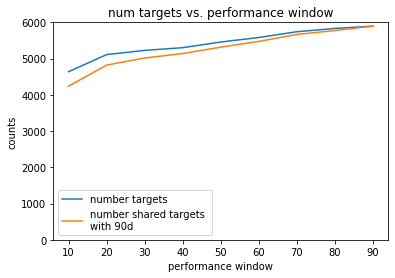

In [10]:
table.T['num targets'].plot(label='number targets')
table.T['number shared targets'].plot(label='number shared targets \nwith 90d')
plt.xlabel('performance window')
plt.ylabel('counts')
plt.yticks(1000*np.arange(7))
plt.legend()
plt.title('num targets vs. performance window')

Text(0.5, 1.0, 'total dollar amount of deposits vs. performance window')

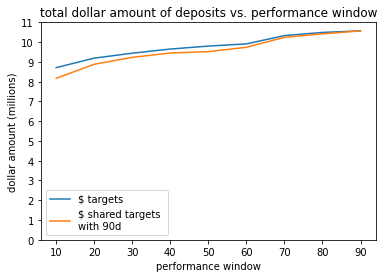

In [13]:
table.T['total target dollar amount (Millions)'].plot(label='$ targets')
table.T['shared targets ACH total amount (Millons)'].plot(label='$ shared targets \nwith 90d')
plt.xlabel('performance window')
plt.ylabel('dollar amount (millions)')
plt.yticks(np.arange(12))
plt.legend()
plt.title('total dollar amount of deposits vs. performance window')

In [12]:
print(table.to_csv())

,10,20,30,40,50,60,70,80,90
num targets,4638.0,5110.0,5227.0,5301.0,5458.0,5582.0,5741.0,5832.0,5896.0
number shared targets,4240.0,4821.0,5016.0,5140.0,5317.0,5474.0,5667.0,5775.0,5896.0
shared to total target ratio,0.91,0.94,0.96,0.97,0.97,0.98,0.99,0.99,1.0
total target dollar amount (Millions),8.71,9.19,9.44,9.65,9.8,9.91,10.33,10.49,10.57
shared targets ACH total amount (Millons),8.17,8.88,9.23,9.45,9.52,9.74,10.24,10.42,10.57

